# Regularized linear regression

In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import (
    LogisticRegression,
    Lasso, 
    Ridge, 
    LassoCV, 
    RidgeCV
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv', sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [3]:
df_raw.sample(10, random_state=2025)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
120,5023,24965,2423,9.705588,2757,11.043461,2332,9.341078,2541,10.178250,...,2302,14.6,13.3,15.8,2946,3.9,3.6,4.2,790,6
686,17187,17032,2047,12.018553,2427,14.249648,2193,12.875763,1901,11.161343,...,1175,11.5,10.5,12.5,1525,3.2,3.0,3.5,430,6
3098,55105,163129,19981,12.248589,21849,13.393695,19982,12.249202,20353,12.476629,...,8680,10.4,9.5,11.2,13020,3.0,2.8,3.3,3784,4
1512,29063,12630,1193,9.445764,1189,9.414093,1835,14.528899,1942,15.376089,...,984,12.0,11.1,13.0,1258,3.1,2.9,3.3,322,4
2836,51036,6941,536,7.722230,636,9.162945,734,10.574845,670,9.652788,...,600,17.7,16.7,18.7,1043,4.3,4.1,4.6,254,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2
2559,48077,10456,1041,9.956006,1271,12.155700,998,9.544759,1070,10.233359,...,771,13.5,12.3,14.6,1125,3.5,3.3,3.8,294,4
2727,48413,2895,339,11.709845,490,16.925734,293,10.120898,384,13.264249,...,154,14.2,13.3,15.1,306,3.4,3.2,3.7,74,6
2311,44005,82542,7243,8.774927,9194,11.138572,10520,12.745027,9527,11.542003,...,4598,9.3,8.4,10.4,6410,2.8,2.6,3.1,1922,2
1306,26155,68192,7384,10.828250,8728,12.799155,8258,12.109925,7597,11.140603,...,5037,11.0,10.1,11.9,5936,3.1,2.9,3.4,1682,5


In [4]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.replace('-','_').str.replace('/','_').str.replace('%','_').str.replace(' ','_').str.lower()
#escalamiento de variables
data_types = df_baking.dtypes
numeric_columns = [c for c in list(data_types[data_types != "object"].index) if c != "heart_disease_number"]

scaler = StandardScaler()
norm_features = scaler.fit_transform(df_baking[numeric_columns])

# Create a new DataFrame with the scaled numerical variables
df_baking_scal = pd.DataFrame(norm_features, index = df_baking.index, columns = numeric_columns)
df_baking_scal["heart_disease_number"] = df_baking["heart_disease_number"]
df = df_baking_scal.copy()
df.head()

,fips,tot_pop,0_9,0_9_y_o___of_total_pop,19_oct,10_19_y_o___of_total_pop,20_29,20_29_y_o___of_total_pop,30_39,30_39_y_o___of_total_pop,...,diabetes_prevalence,diabetes_lower_95__ci,diabetes_upper_95__ci,diabetes_number,ckd_prevalence,ckd_lower_95__ci,ckd_upper_95__ci,ckd_number,urban_rural_code,heart_disease_number
0,-1.940874,-0.145679,-0.142421,0.158006,-0.135556,0.573496,-0.153144,0.027610,-0.139384,0.588469,...,-0.063696,-0.071720,-0.089834,-0.129902,-0.609615,-0.582796,-0.669652,-0.147523,-1.082865,3345
1,-1.940742,0.341296,0.287476,-0.242861,0.320383,-0.193107,0.183774,-0.469965,0.230620,-0.110300,...,-0.394103,-0.414900,-0.337677,0.376251,-0.433549,-0.393279,-0.343373,0.389791,-0.420704,13414
2,-1.940610,-0.237785,-0.239429,-0.419441,-0.246181,-0.439718,-0.225971,0.272104,-0.218759,0.656538,...,2.432709,2.483064,2.317776,-0.183415,1.855312,1.880929,1.777443,-0.204321,0.903618,2159
3,-1.940478,-0.245223,-0.246032,-0.426966,-0.254791,-0.609076,-0.230792,0.396168,-0.220555,1.264959,...,0.376846,0.423984,0.299632,-0.229096,-0.257483,-0.203761,-0.180233,-0.242100,-1.745026,1533
4,-1.940346,-0.138966,-0.135053,0.186249,-0.137140,0.216679,-0.155888,-0.200808,-0.143570,0.088582,...,0.156575,0.195197,0.158008,-0.111247,-0.081417,-0.014244,-0.017093,-0.124105,-1.745026,4101


In [5]:
df_train, df_test = train_test_split(df,test_size=0.2,random_state=2025)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Columns: 106 entries, fips to heart_disease_number
dtypes: float64(105), int64(1)
memory usage: 2.0 MB


In [6]:
X_train = df_train.drop('heart_disease_number', axis=1)
y_train = df_train['heart_disease_number']
X_test = df_test.drop('heart_disease_number', axis=1)
y_test = df_test['heart_disease_number']

In [7]:
k = int(len(X_train.columns) * 0.3)
selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()

X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel

,tot_pop,0_9,19_oct,20_29,30_39,40_49,50_59,60_69,70_79,80+,...,family_medicine_general_practice_primary_care_(2019),total_specialist_physicians_(2019),total_population,population_aged_60+,county_pop2018_18_and_older,anycondition_number,obesity_number,copd_number,diabetes_number,ckd_number
0,0.171395,-0.023643,0.272532,0.382282,0.048946,0.073640,0.160814,0.239874,0.221831,0.201997,...,0.012624,0.584025,0.179604,0.221871,0.219947,0.108400,0.102423,0.121246,0.050098,0.125339
1,-0.267497,-0.258927,-0.272910,-0.254900,-0.240828,-0.256808,-0.275860,-0.285347,-0.302171,-0.290382,...,-0.259891,-0.282229,-0.263565,-0.291582,-0.267963,-0.287915,-0.288901,-0.314367,-0.271886,-0.273668
2,-0.068163,-0.066920,-0.060670,-0.089113,-0.094736,-0.070153,-0.059817,-0.043062,-0.034426,-0.043571,...,-0.096209,-0.091774,-0.063495,-0.032445,-0.069796,-0.030812,-0.028368,0.025433,0.022065,0.007215
3,-0.264706,-0.260195,-0.270757,-0.251995,-0.243032,-0.253311,-0.269469,-0.289867,-0.286888,-0.267334,...,-0.287103,-0.261098,-0.262764,-0.282200,-0.264636,-0.270812,-0.274127,-0.276068,-0.245197,-0.252579
4,0.265903,0.385705,0.271752,0.263682,0.316037,0.219412,0.228707,0.251435,0.122839,0.169829,...,0.554129,0.077553,0.248019,0.183432,0.243775,0.212111,0.257416,0.077602,0.109763,0.145004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,0.037654,-0.026729,-0.017716,-0.060184,-0.029612,0.022266,0.050545,0.169002,0.328121,0.268902,...,0.006374,0.001995,0.030242,0.230113,0.053635,0.069177,0.054716,0.153312,0.082233,0.103991
2508,-0.287438,-0.287252,-0.294718,-0.271603,-0.264101,-0.273350,-0.291077,-0.308643,-0.316320,-0.300082,...,-0.295368,-0.277067,-0.285216,-0.308651,-0.286104,-0.302510,-0.305744,-0.321175,-0.281701,-0.285830
2509,5.537940,5.098359,5.087960,4.627506,5.127753,5.728707,6.241655,6.068996,6.487032,6.768562,...,5.356348,4.602330,5.446225,6.277418,5.639387,6.026640,5.818118,6.897215,6.445489,6.312273
2510,-0.198415,-0.208186,-0.211317,-0.186047,-0.188218,-0.182703,-0.201598,-0.196106,-0.207713,-0.212699,...,-0.208152,-0.211598,-0.190926,-0.195093,-0.194522,-0.179976,-0.191017,-0.149016,-0.169936,-0.175340


In [8]:
lreg_p = Pipeline([
    ('lreg', LogisticRegression(max_iter=1000))
])

In [9]:
lreg_p.fit(X_train_sel, y_train)

Pipeline(steps=[('lreg', LogisticRegression(max_iter=1000))])

In [10]:
y_hat = lreg_p.predict(X_test_sel)
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2: {r2_score(y_test, y_hat)}')

MSE: 39688097.43789809
RMSE: 6299.84900119821
R2: 0.8537491605572191


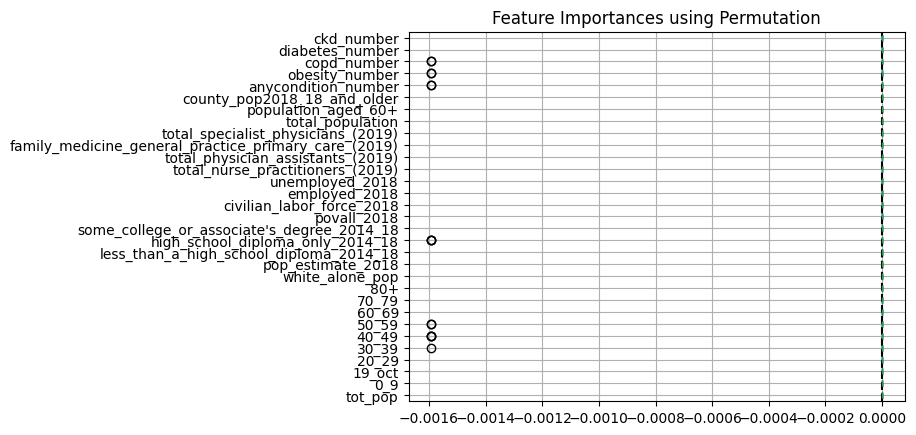

In [11]:
importance = permutation_importance(lreg_p, X_test_sel, y_test, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_test_sel.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color='k',linestyle='--')
ax.set_title('Feature Importances using Permutation')
ax.grid(True)
plt.show()

In [13]:
#Lasso
cv = RepeatedKFold(n_splits=15,n_repeats=5,random_state=2025)
lreg_ridge = RidgeCV(alphas=np.arange(0,1,0.01),cv=cv)
lreg_ridge.fit(X_train_sel,y_train)

/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.73513e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.79403e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.03175e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/workspaces/machine-learning-python-template/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.47139e-18): result may not be acc

RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=5, n_splits=15, random_state=2025))

In [14]:
lreg_ridge.alpha_

np.float64(0.61)

In [16]:
lreg_ridge_p = Pipeline([
    ('lreg_ridge', Ridge(alpha=0.61))
])

In [17]:
lreg_ridge_p.fit(X_train_sel, y_train)

Pipeline(steps=[('lreg_ridge', Ridge(alpha=0.61))])

In [19]:
y_hat = lreg_ridge_p.predict(X_test_sel)
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')
print(f'R2: {r2_score(y_test, y_hat)}')

MSE: 489755.8430095049
RMSE: 699.8255804195106
R2: 0.998195247245746


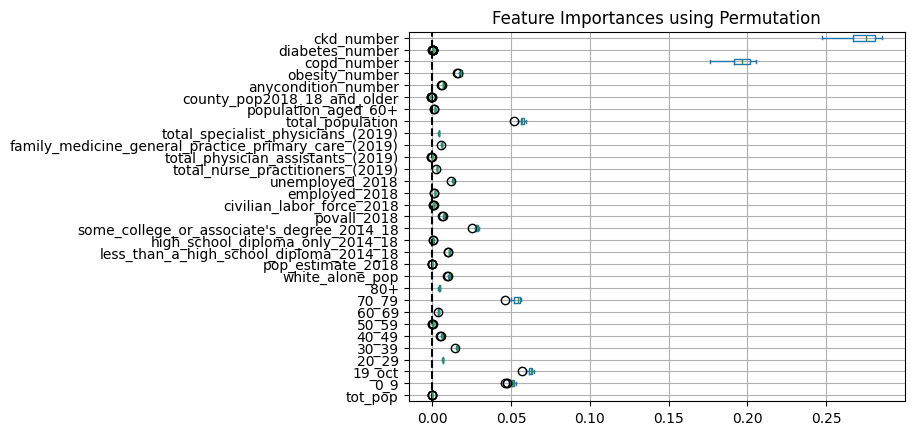

In [21]:
importance = permutation_importance(lreg_ridge_p, X_test_sel, y_test, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_test_sel.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color='k',linestyle='--')
ax.set_title('Feature Importances using Permutation')
ax.grid(True)
plt.show()